# Random forest regression with hyperparameter tuning by GPyOpt

### Import library and dataset

In [1]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import GPy, GPyOpt
from GPyOpt.methods import BayesianOptimization

import pickle

In [2]:
# load dataset
df = pd.read_csv('./data_common/df_source.csv')
print(df.shape)
df.head()

(594, 12)


,Kod,GlasNo,SiO2,B2O3,Al2O3,MgO,CaO,Na2O,K2O,E,density,Tg
0,2498,34459,71.01,0.45,0.31,0.0,13.01,12.13,3.08,71.8,2.51,540.0
1,2498,34460,71.77,11.09,0.25,0.0,0.00,9.76,6.29,82.5,2.52,538.0
2,3714,10815,75.01,0.00,0.00,0.0,10.69,14.30,0.00,77.5,2.46,548.0
3,3714,10817,69.93,5.08,0.00,0.0,10.71,14.29,0.00,80.4,2.51,563.0
4,3724,10860,52.50,24.30,0.00,0.0,0.00,23.20,0.00,80.4,2.56,529.0


In [3]:
# Shuffle the dataset just in case

df_s = df.sample(frac = 1, random_state = 0)
print(df_s.shape)
df_s.head()

(594, 12)


,Kod,GlasNo,SiO2,B2O3,Al2O3,MgO,CaO,Na2O,K2O,E,density,Tg
240,39756,465909,40.00,40.00,0.00,0.00,0.00,20.00,0.00,75.1,2.42,545.0
132,27734,359612,72.00,0.00,0.00,14.00,0.00,14.00,0.00,70.2,2.45,551.0
424,42246,483234,52.60,20.60,0.00,0.00,0.00,26.80,0.00,80.3,2.54,535.0
92,16195,134085,79.40,10.44,2.48,0.78,1.13,4.08,0.67,66.0,2.34,550.0
170,30511,401108,67.35,0.00,10.49,5.29,0.35,13.45,2.40,72.0,2.43,623.0


In [4]:
# Get column number for computation

start = df_s.columns.get_loc('SiO2')
end   = df_s.columns.get_loc('K2O') + 1
print('Column the composition starts = ', start)
print('Column the composition ends   = ', end)

Column the composition starts =  2
Column the composition ends   =  9


In [5]:
# Define X variables

X = df_s.iloc[:, start:end]

In [6]:
print(X.shape)
X.head()

(594, 7)


,SiO2,B2O3,Al2O3,MgO,CaO,Na2O,K2O
240,40.00,40.00,0.00,0.00,0.00,20.00,0.00
132,72.00,0.00,0.00,14.00,0.00,14.00,0.00
424,52.60,20.60,0.00,0.00,0.00,26.80,0.00
92,79.40,10.44,2.48,0.78,1.13,4.08,0.67
170,67.35,0.00,10.49,5.29,0.35,13.45,2.40


In [7]:
# Define target y value

def choose_y(df, property):
    y_value  = df[property]
    return y_value

In [8]:
property_name = 'density'

In [9]:
y = choose_y(df_s, property_name)
print(y.shape)
y.head()

(594,)


240    2.42
132    2.45
424    2.54
92     2.34
170    2.43
Name: density, dtype: float64

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(475, 7) (119, 7) (475,) (119,)


### Default

In [11]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [12]:
pred_rfr = rfr.predict(X_test)
R2_rfr = r2_score(pred_rfr, y_test)
print('R2 = ', R2_rfr)

R2 =  0.8009129054449335


### Hyperparameter tuning using GPyOpt

In [13]:
# GPyOpt for RF regression

bounds_rfr = [
    {'name': 'n_estimators', 'type': 'discrete', 'domain': tuple(range(5, 500))},
    {'name': 'max_depth', 'type': 'discrete', 'domain': tuple(range(1, 300))},
    {'name': 'min_sample_split', 'type': 'discrete', 'domain': tuple(range(2, 20))},
    {'name': 'min_samples_leaf', 'type': 'discrete', 'domain': tuple(range(1, 10))}
]

# Optimization objective function

def rmse_rfr(*args):
    params = args[0]
    
    rfr = RandomForestRegressor(n_estimators = int(params[0][0]),
                                max_depth = int(params[0][1]),
                                min_samples_split = int(params[0][2]),
                                min_samples_leaf = int(params[0][3]),
                                bootstrap = True,
                                random_state = 0,
                                criterion = 'mse')
                
    rfr.fit(X_train, y_train)
    
    pred_rfr = rfr.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(pred_rfr, y_test))
    
    return RMSE

In [14]:
%%time

optimizer = BayesianOptimization(f = rmse_rfr, domain = bounds_rfr)
optimizer.run_optimization(max_iter = 100)

Wall time: 2min 17s


In [15]:
optimizer.x_opt

array([459., 202.,   2.,   1.])

In [16]:
rfr_best = RandomForestRegressor(n_estimators = int(optimizer.x_opt[0]),
                                 max_depth = int(optimizer.x_opt[1]),
                                 min_samples_split = int(optimizer.x_opt[2]),
                                 min_samples_leaf = int(optimizer.x_opt[3]),
                                 bootstrap = True,
                                 random_state = 0,
                                 criterion = 'mse')

rfr_best.fit(X_train, y_train)
y_pred_rfr = rfr_best.predict(X_test)

print('R2 = ', '{:.4}'.format(r2_score(y_pred_rfr, y_test)))

R2 =  0.8188


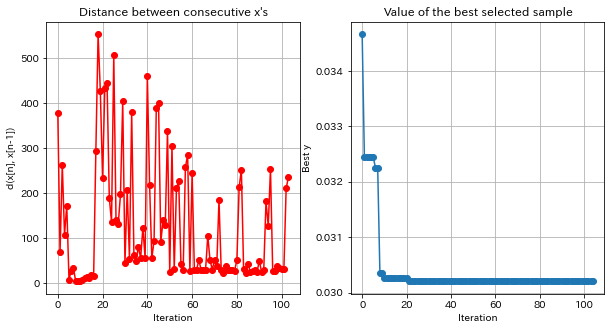

In [17]:
optimizer.plot_convergence()

### Check model performance by CV

R2 =   0.9808


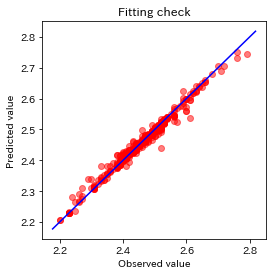

In [18]:
# Use all data
X_train, y_train = X, y

rfr_best = RandomForestRegressor(n_estimators = int(optimizer.x_opt[0]),
                                 max_depth = int(optimizer.x_opt[1]),
                                 min_samples_split = int(optimizer.x_opt[2]),
                                 min_samples_leaf = int(optimizer.x_opt[3]),
                                 bootstrap = True,
                                 random_state = 0,
                                 criterion = 'mse')

rfr_best.fit(X_train, y_train)
y_pred = rfr_best.predict(X_train)

print('R2 = ', ' {:.4}'.format(r2_score(y, y_pred)))

plt.figure(figsize = [4, 4])
slp_1_begin = 0.99 * y.min()
slp_1_end   = 1.01 * y.max()

plt.scatter(y, y_pred, c = 'r', alpha = 0.5)
plt.plot([slp_1_begin, slp_1_end], [slp_1_begin, slp_1_end], c = 'b')
plt.title('Fitting check')
plt.xlabel('Observed value')
plt.ylabel('Predicted value')
plt.show()

In [19]:
# Save the best model

import pickle
with open('./data_common/best_RF_density.pickle', mode='wb') as f:
    pickle.dump(rfr_best, f)